In [1]:
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
from data_prep import data_pipeline
import pandas as pd 
import numpy as np 
import xgboost as xgb
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt 

plt.rcParams["figure.figsize"] = (30, 10)
sns.set(rc={'figure.figsize':(30, 10)})

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
DATA_PATH = Path(os.getcwd()) / 'data' / 'WEC2022_Data'
MODEL_TYPE = 'predict_when_upgrade'
DATA_TYPE = 'train'

In [3]:
df = data_pipeline(data_path=DATA_PATH, model_type=MODEL_TYPE, data_type=DATA_TYPE)

In [ ]:
df = df[df['purchase_time_diff'] > 5]

In [114]:
df.to_csv('model_2_df.csv')

In [29]:
X = df.drop(columns='purchase_time_diff')
Y = df['purchase_time_diff']

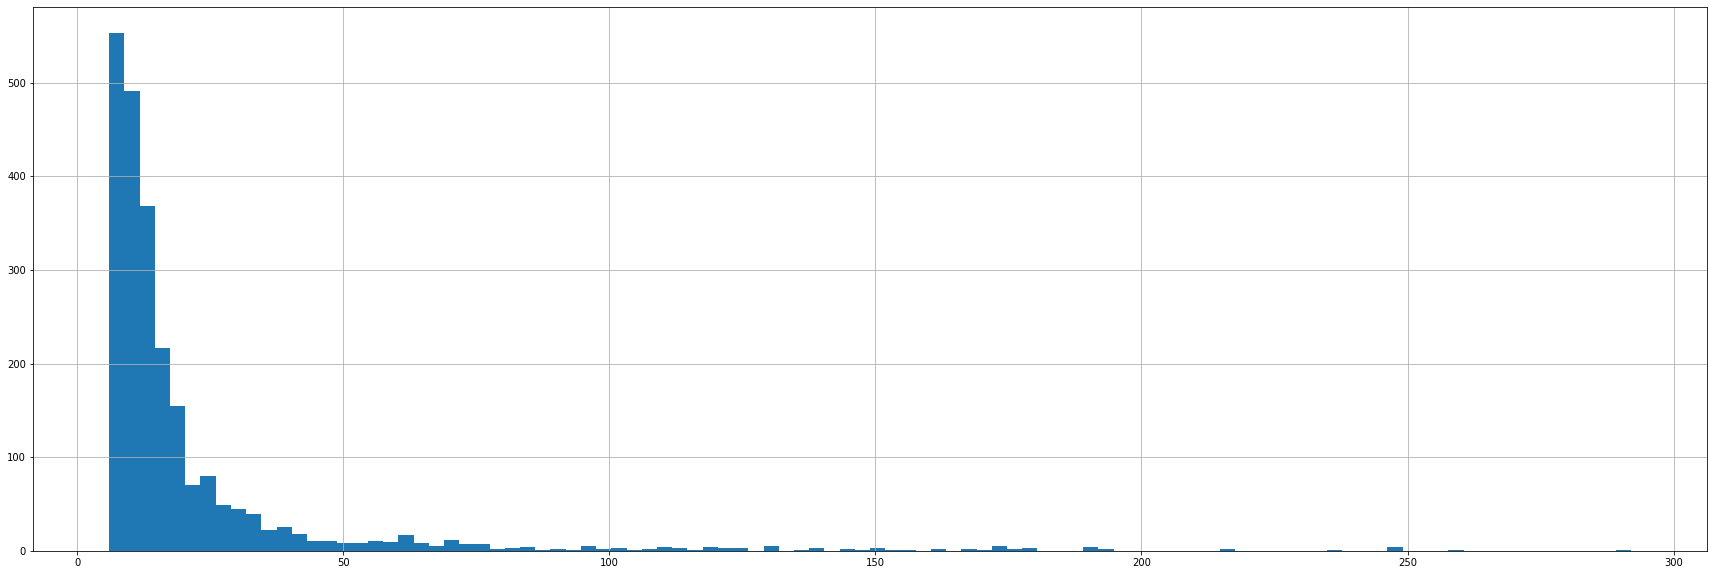

In [30]:
df['purchase_time_diff'].hist(bins=100)
plt.show()

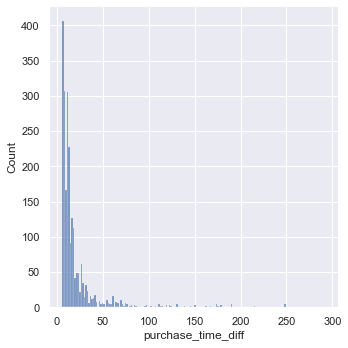

In [44]:
sns.displot(df['purchase_time_diff'], kind='hist')

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)


In [80]:
def eval(y_real, y_pred):
    err = y_real - y_pred
    mae = abs(err).mean()
    mse = (err ** 2).mean().round(2)
    rmse = ((err ** 2).mean() ** (0.5)).round(2)
    return mae, rmse, mse

In [93]:
def train_eval_model(params, X, y):
    params['n_estimators'] = int(params['n_estimators'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    xgb_model = xgb.XGBRegressor(
    seed=42,
    use_label_encoder=False,
    tree_method="gpu_hist",
    gpu_id=0, **params
)
    xgb_model.fit(X_train, y_train, eval_metric="rmse")
    preds = xgb_model.predict(X_test)
    mae, rmse, mse = eval(y_test, preds)
    return xgb_model, mae, rmse, mse 

In [89]:
xgb_model = xgb.XGBRegressor(
    seed=42,
    use_label_encoder=False,
    tree_method="gpu_hist",
    gpu_id=0, 
)
xgb_model.fit(X_train, y_train, eval_metric="rmse")


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='gpu_hist', use_label_encoder=False,
             validate_parameters=1, verbosity=None)

In [59]:
preds = xgb_model.predict(X_test)
mae, rmse, mse = eval(y_test, preds)

In [60]:
mae

2.6663439803653293

In [61]:
rmse

8.71

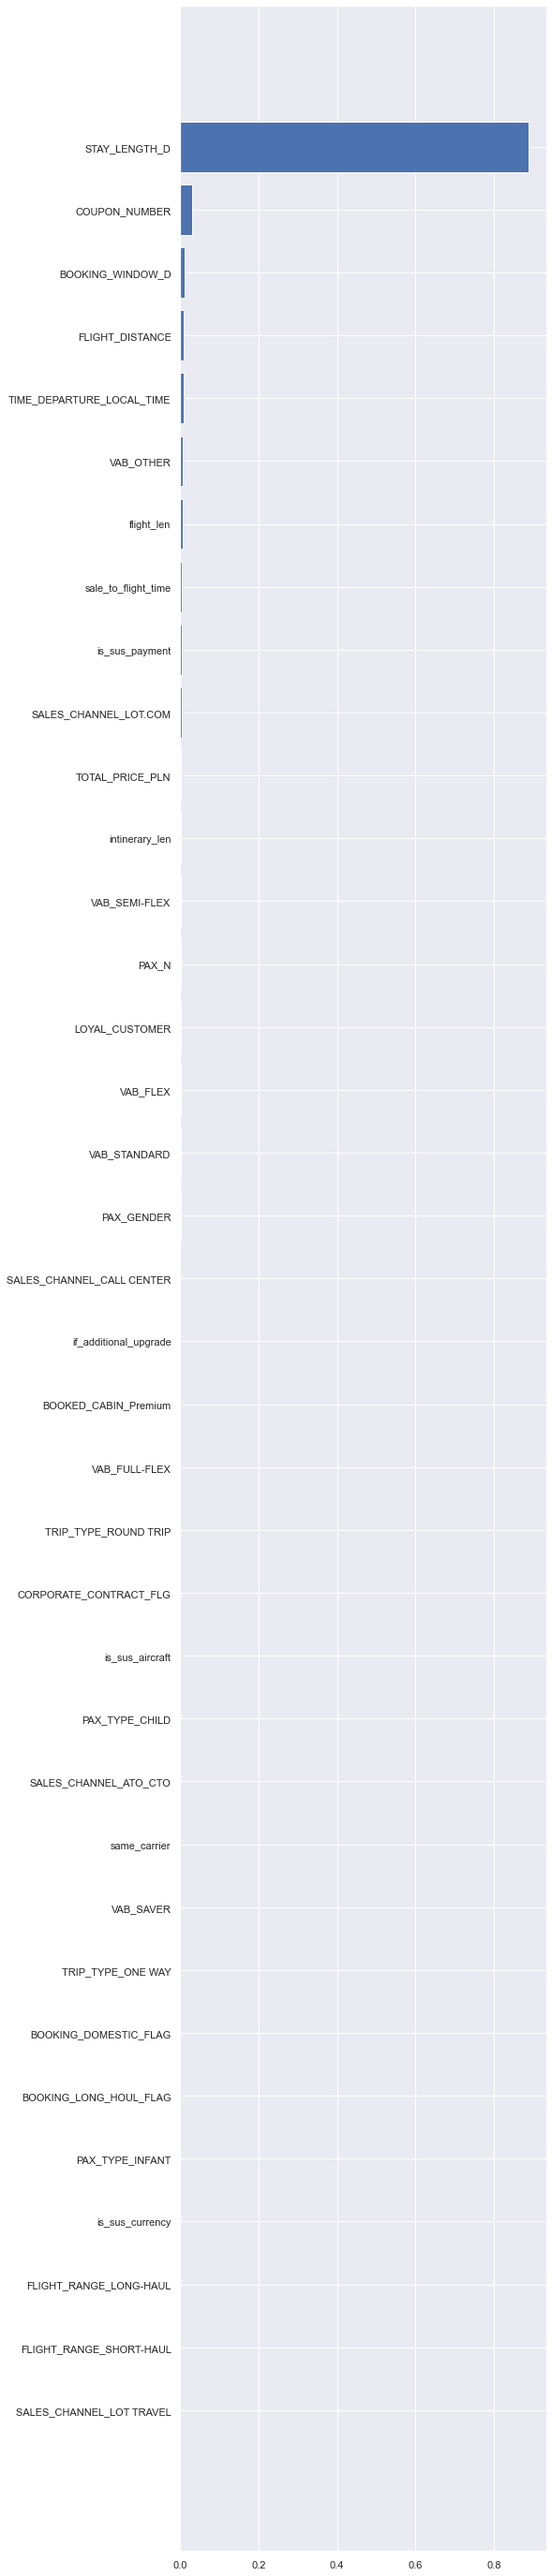

In [63]:
sorted_idx = xgb_model.feature_importances_.argsort()
plt.figure(figsize=(7,50))
plt.barh(X_train.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.show()

In [81]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb
from sklearn.metrics import roc_auc_score


def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    gbm_model = xgb.train(params, dtrain, num_round,
                          verbose_eval=True)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    mae, rmse, mse = eval(y_test, predictions)
    print(f'MAE: {mae} - RMSE: {rmse} - MSE: {mse}')
    return {'loss': mse, 'status': STATUS_OK}

def optimize(trials):

    space = {
        'n_estimators': hp.quniform('n_estimators', 10, 300, 1),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(1, 16, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'objective': 'reg:squarederror',
        'booster': 'gbtree',
        'tree_method': 'auto',
        'tree_method': "gpu_hist",
        'gpu_id': 0,
    }

    best = fmin(score, 
                space, 
                algo=tpe.suggest,
                trials=trials, 
                max_evals=100)
    return best

In [79]:
trials = Trials()

best_hypers = optimize(trials)

Training with params:                                  
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.17500000000000002, 'gamma': 0.6000000000000001, 'gpu_id': 0, 'max_depth': 7, 'min_child_weight': 2.0, 'n_estimators': 229.0, 'objective': 'reg:squarederror', 'subsample': 0.5, 'tree_method': 'gpu_hist'}
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



MAE: 2.796924146831545 - RMSE: 8.32                    
Training with params:                                                           
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.275, 'gamma': 0.65, 'gpu_id': 0, 'max_depth': 6, 'min_child_weight': 5.0, 'n_estimators': 220.0, 'objective': 'reg:squarederror', 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
  1%|          | 1/100 [00:02<03:38,  2.21s/trial, best loss: 2.796924146831545]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



MAE: 3.6279607506898732 - RMSE: 9.57                                            
Training with params:                                                           
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.225, 'gamma': 0.6000000000000001, 'gpu_id': 0, 'max_depth': 2, 'min_child_weight': 5.0, 'n_estimators': 205.0, 'objective': 'reg:squarederror', 'subsample': 0.8, 'tree_method': 'gpu_hist'}
MAE: 3.1373597908223796 - RMSE: 8.0                                             
Training with params:                                                           
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.17500000000000002, 'gamma': 0.75, 'gpu_id': 0, 'max_depth': 1, 'min_child_weight': 1.0, 'n_estimators': 14.0, 'objective': 'reg:squarederror', 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
MAE: 7.871203204505464 - RMSE: 13.51                                            
Training with params:                                                       

In [82]:
trials = Trials()

best_hypers_mse = optimize(trials)

Training with params:                                  
{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.30000000000000004, 'gamma': 0.75, 'gpu_id': 0, 'max_depth': 9, 'min_child_weight': 2.0, 'n_estimators': 153.0, 'objective': 'reg:squarederror', 'subsample': 0.7000000000000001, 'tree_method': 'gpu_hist'}
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



MAE: 5.913819359153764 - RMSE: 13.43 - MSE: 180.33     
Training with params:                                                
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.47500000000000003, 'gamma': 0.6000000000000001, 'gpu_id': 0, 'max_depth': 1, 'min_child_weight': 5.0, 'n_estimators': 282.0, 'objective': 'reg:squarederror', 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
  1%|          | 1/100 [00:01<03:13,  1.96s/trial, best loss: 180.33]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



MAE: 3.510752870486333 - RMSE: 8.47 - MSE: 71.76                     
Training with params:                                                
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.4, 'gamma': 0.65, 'gpu_id': 0, 'max_depth': 4, 'min_child_weight': 6.0, 'n_estimators': 156.0, 'objective': 'reg:squarederror', 'subsample': 0.55, 'tree_method': 'gpu_hist'}
MAE: 3.479270207066821 - RMSE: 8.38 - MSE: 70.23                    
Training with params:                                               
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.125, 'gamma': 0.8, 'gpu_id': 0, 'max_depth': 7, 'min_child_weight': 5.0, 'n_estimators': 194.0, 'objective': 'reg:squarederror', 'subsample': 0.75, 'tree_method': 'gpu_hist'}
MAE: 3.4320360417039986 - RMSE: 8.99 - MSE: 80.85                   
Training with params:                                               
{'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.1, 'gamma': 1.0, 'gpu_id': 0, 'max_d

In [94]:
xgb_model, mae, rmse, mse = train_eval_model(best_hypers, X, Y)

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [95]:
xgb_model_2, mae_2, rmse_2, mse_2 = train_eval_model(best_hypers, X, Y)

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [96]:
print(mae)
print(mae_2)

2.329384255613017
2.868498383424221


In [97]:
print(rmse)
print(rmse_2)

7.53
11.37


In [106]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb
xgb_model = xgb.XGBRegressor(**best_hypers,
                                  seed=42,
                                  use_label_encoder=False, 
                                  tree_method="gpu_hist",
                                  gpu_id=0,)
kfold = KFold(n_splits=5)
results = cross_val_score(xgb_model, X["STAY_LENGTH_D"], Y, cv=kfold, scoring='neg_mean_absolute_error', fit_params={'eval_metric':'mae'})
print("średnia:", results.mean())
print('mae:', results)

prev_result = results.mean()



col_list = ['STAY_LENGTH_D']
all_cols = ['STAY_LENGTH_D',
 'COUPON_NUMBER',
 'TIME_DEPARTURE_LOCAL_TIME',
 'FLIGHT_DISTANCE',
 'TOTAL_PRICE_PLN',
 'BOOKING_DOMESTIC_FLAG',
 'PAX_N',
 'sale_to_flight_time',
 'flight_len',
 'same_carrier',
 'is_sus_currency',
 'FLIGHT_RANGE_LONG-HAUL',
 'FLIGHT_RANGE_SHORT-HAUL',
 'VAB_SAVER',
 'PAX_TYPE_INFANT',
 'TRIP_TYPE_ONE WAY',
 'TRIP_TYPE_ROUND TRIP']

x = 0

while x < len(all_cols):
    if len(results) != 1 and results.mean() > prev_result:
        prev_result = results.mean()
    while all_cols[x] in col_list:
        x += 1
    else:
        col_list.append(all_cols[x])
    kolumny = X[col_list]
    xgb_model = xgb.XGBRegressor(**best_hypers,
                                  seed=42,
                                  use_label_encoder=False, 
                                  tree_method="gpu_hist",
                                  gpu_id=0,)
    kfold = KFold(n_splits=5)
    results = cross_val_score(xgb_model, kolumny, Y, cv=kfold, scoring='neg_mean_absolute_error', fit_params={'eval_metric':'mae'})
    print("średnia:", results.mean())
    print('mae:', results)
    print('kolumny:', kolumny.columns)
    if prev_result > results.mean():
        col_list.remove(all_cols[x])
    x += 1


średnia: -3.15286172150575
auc score: [-2.87187971 -3.48112811 -3.59967333 -3.4040192  -2.40760826]
średnia: -2.8419389975271896
mae: [-2.7532126  -2.91930205 -3.10993039 -3.00258759 -2.42466235]
kolumny: Index(['STAY_LENGTH_D', 'COUPON_NUMBER'], dtype='object')
średnia: -2.7149831574024232
mae: [-2.75608022 -2.58455622 -2.66325454 -2.87023804 -2.70078677]
kolumny: Index(['STAY_LENGTH_D', 'COUPON_NUMBER', 'TIME_DEPARTURE_LOCAL_TIME'], dtype='object')
średnia: -2.591309223160824
mae: [-2.47497457 -2.40501103 -2.87144972 -2.64426746 -2.56084333]
kolumny: Index(['STAY_LENGTH_D', 'COUPON_NUMBER', 'TIME_DEPARTURE_LOCAL_TIME',
       'FLIGHT_DISTANCE'],
      dtype='object')
średnia: -2.438297631764613
mae: [-2.21466825 -2.30639519 -2.67460593 -2.44822273 -2.54759606]
kolumny: Index(['STAY_LENGTH_D', 'COUPON_NUMBER', 'TIME_DEPARTURE_LOCAL_TIME',
       'FLIGHT_DISTANCE', 'TOTAL_PRICE_PLN'],
      dtype='object')
średnia: -2.483363315966562
mae: [-2.25325149 -2.29454816 -2.74430815 -2.5231187

In [108]:
col_list

['STAY_LENGTH_D',
 'COUPON_NUMBER',
 'TIME_DEPARTURE_LOCAL_TIME',
 'FLIGHT_DISTANCE',
 'TOTAL_PRICE_PLN',
 'BOOKING_DOMESTIC_FLAG',
 'PAX_N',
 'sale_to_flight_time',
 'flight_len',
 'same_carrier',
 'is_sus_currency',
 'FLIGHT_RANGE_LONG-HAUL',
 'FLIGHT_RANGE_SHORT-HAUL',
 'VAB_SAVER',
 'PAX_TYPE_INFANT',
 'TRIP_TYPE_ONE WAY',
 'TRIP_TYPE_ROUND TRIP']

In [101]:
import sklearn
(sklearn.metrics.SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [109]:
xgb_model, mae, rmse, mse = train_eval_model(best_hypers, X[col_list], Y)

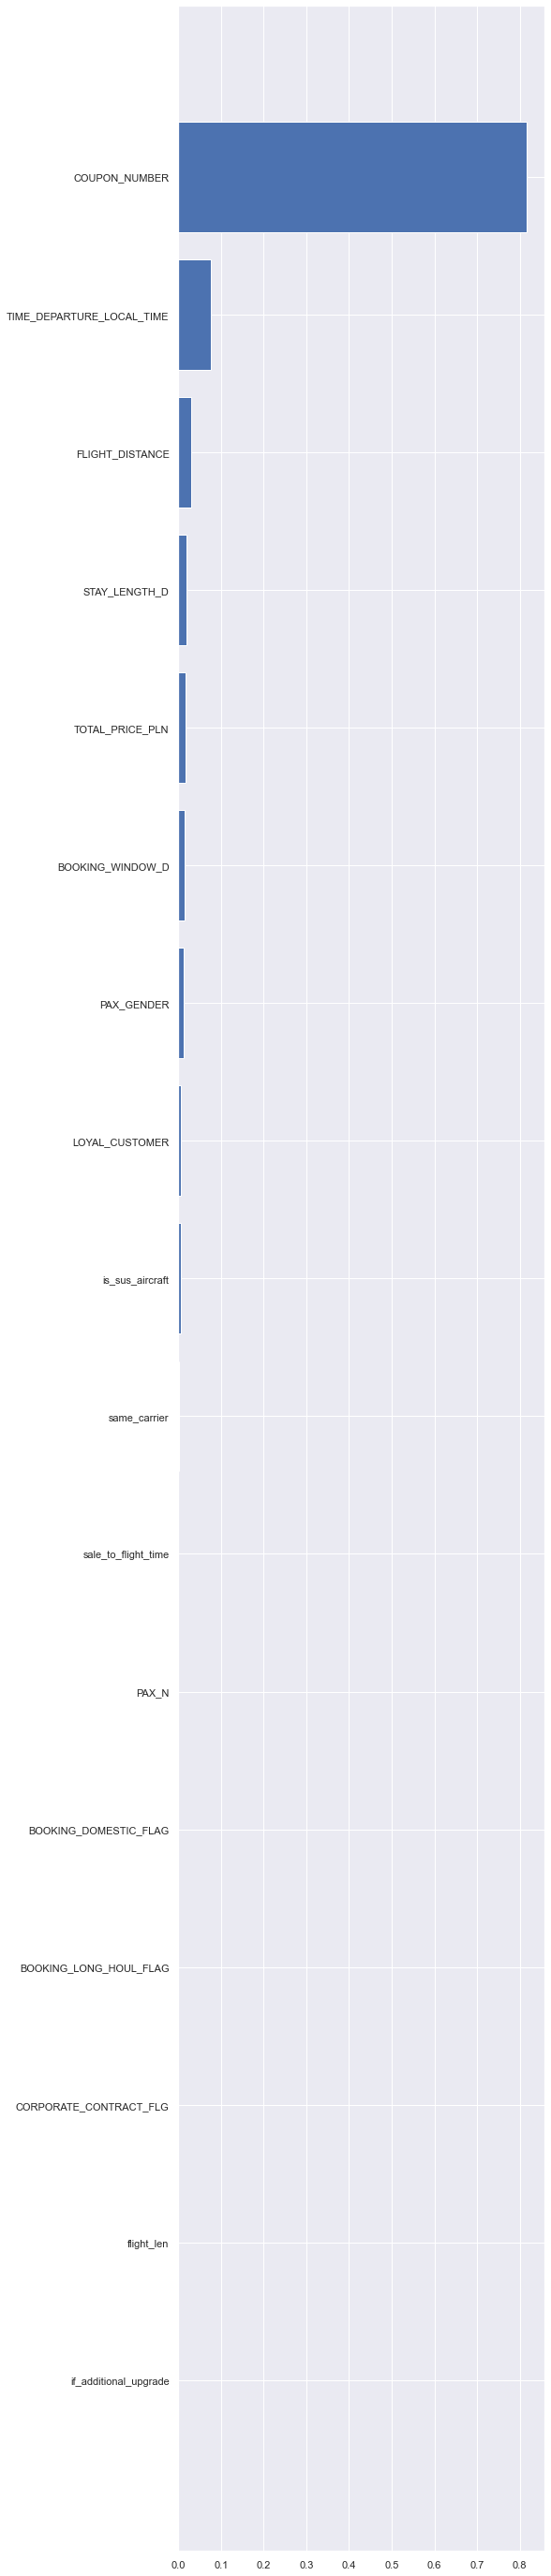

In [111]:
sorted_idx = xgb_model.feature_importances_.argsort()
plt.figure(figsize=(7,50))
plt.barh(X_train.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.show()

In [ ]:
import dalex as dx
przyklad = X_test.iloc[42]
xgb_exp = dx.Explainer(xgb_model, X[col_list], Y, label='XGB Pipeline')


In [ ]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"